# Analyze the Impact of UE Capability on Blocking Probability

* In this notebook, we simulate the impact of UE capability in terms of Blind Decoding (BD)/ CCE limits  on the  `blocking probability` 


* When BD/CCE limits is reduced, UE can monitor a fewer number of CCEs per slot. This can also limit the scheduling flexibilty and increases blocking probability.


* For evaluation, we consider the following cases:
    * **Reference Case:** Assuming that the UE is configured to monitor [6,6,4,2,1] PDCCH candiates for ALs                   [1,2,4,8,16].
    
    * **Reduced BD Case A:** Assuming that the UE is configured to monitor [3,3,2,1,1] PDCCH candiates for ALs                 [1,2,4,8,16],. In this case BD limit is reduced by 50% compared to reference case.
    
    * **Reduced BD Case B:** Assuming that the UE is configured to monitor [1,1,1,1,1] PDCCH candiates for ALs                 [1,2,4,8,16]. In this case BD limit  is reduced by around 75% compared to reference case.


## Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np

## 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../")
from toolkit5G.Scheduler import PDCCHScheduler

## Simulation Parameters
The following parameters are used for this simulation:
- `coresetID` denotes the coreset ID.
- `slotNumber` denotes the slot-number carrying the PDCCH.
- `searchSpaceType` denotes the search space type. UE specific search space (USS) or Common search space (CSS).
- `nci` denotes the variable corresponding to carrier aggregation. Current simulation does not assume carrier aggregation.

In [3]:

mu                = np.random.randint(4)    # numerlogy for sub-carrier spacing
numSlotsPerFrame  = 2**mu * 10              # number of slots per radio frame
coresetID         = 1                       # coreset ID
slotNumber        = 0               
searchSpaceType   = "USS"                   # search space type. UE specific search space
nci               = 0                       # variable corresponding to carrier aggregation 
numIterations     = 1000
numUEs            = 20                      # number of UEs in simulation


## PDCCH Scheduling Parameters
Following parameters are crucial for PDCCH scheduling performance:
- ``coresetSize `` denotes coreset size or number of CCEs available for scheduling UEs.
- ``strategy`` denotes the scheduling strategy.
- ``numCandidates`` denotes number of PDCCH candidates per each Aggregation Level.

In [4]:

minCCEs                  = 20
maxCCEs                  = 80
coresetSize              = np.arange(minCCEs,maxCCEs+1,10)
strategy                 = "Conservative" 
aggLevelProbDistribution = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
pdcchSchedulerObj        = PDCCHScheduler(mu, slotNumber, coresetID, nci)


## Simulating the Reference Case

In [5]:
#################
# Reference Case
#################

probOfBlockingRefCase    = np.zeros(coresetSize.shape)
numCandidates            = np.array([6,6,4,2,1], dtype=int)


print("##################################################################################################")

for n in range(coresetSize.size):    
    Nccep     = coresetSize[n] 
    print("Current Coreset Size:", Nccep)    
    prob      = 0
    for i in range(numIterations):
        ueALdistribution  = np.random.multinomial(numUEs, aggLevelProbDistribution) 
        rnti              = np.random.choice( np.arange(1,65519+1), size = (numUEs,), replace=False)
        count             = pdcchSchedulerObj(Nccep,searchSpaceType,ueALdistribution,numCandidates,rnti,strategy)[0]
        numBlockedUEs     = np.sum(count)
        prob              = prob + numBlockedUEs/numUEs
    probOfBlockingRefCase[n] = prob/numIterations
print("##################################################################################################")

##################################################################################################
Current Coreset Size: 20
Current Coreset Size: 30
Current Coreset Size: 40
Current Coreset Size: 50
Current Coreset Size: 60
Current Coreset Size: 70
Current Coreset Size: 80
##################################################################################################


### Plot Blocking Probability for Different CORESET Sizes for Different UEs 

* Its the recreation of ``Fig. 5. Blocking probability versus CORESET size (number of CCEs).`` from the reference paper referenced below [1].


* Intuitively as the number of CCEs increases, BS scheduler gets more flexibility to allocate non-ovelapping set of CCEs to each UE and hence the blocking probability decreases.


* From the figure, we see that the blocking probability can be reduced from 0.19 to 0.04 by increasing the number of CCEs in CORESET from 30 to 60.


* Note that the impact of further increasing the CORESET size is minimal as almost all the UEs can be successfully scheduled.

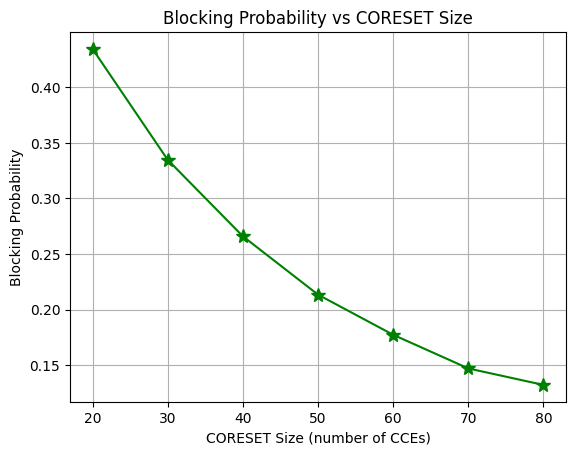

In [6]:
fig, ax = plt.subplots()
ax.plot(coresetSize, probOfBlockingRefCase, marker = "*",linestyle = "solid", ms = 10, c = 'g')
ax.set_xlabel('CORESET Size (number of CCEs)')
ax.set_ylabel('Blocking Probability')
ax.set_title('Blocking Probability vs CORESET Size', fontsize=12) 
ax.set_xticks(coresetSize)
# ax.set_xlim([coresetSize[0], coresetSize[-1]])
ax.grid()
plt.show()

## Simulating Reduced Blind Decoding Case-A

In [7]:
#####################
# Reduced BD Case A
####################

probOfBlockingBDCase_A   = np.zeros(coresetSize.shape)
numCandidates            = np.array([3,3,2,1,1], dtype=int)

print("##################################################################################################")

for n in range(coresetSize.size):    
    Nccep     = coresetSize[n] 
    print("Current Coreset Size:", Nccep)    
    prob      = 0
    for i in range(numIterations):
        ueALdistribution  = np.random.multinomial(numUEs, aggLevelProbDistribution) 
        rnti              = np.random.choice( np.arange(1,65519+1), size = (numUEs,), replace=False)
        count             = pdcchSchedulerObj(Nccep,searchSpaceType,ueALdistribution,numCandidates,rnti,strategy)[0]
        numBlockedUEs     = np.sum(count)
        prob              = prob + numBlockedUEs/numUEs
    probOfBlockingBDCase_A[n] = prob/numIterations
print("##################################################################################################")


##################################################################################################
Current Coreset Size: 20
Current Coreset Size: 30
Current Coreset Size: 40
Current Coreset Size: 50
Current Coreset Size: 60
Current Coreset Size: 70
Current Coreset Size: 80
##################################################################################################


## Simulating Reduced Blind Decoding Case-B

In [8]:
#####################
# Reduced BD Case B
####################

probOfBlockingBDCase_B   = np.zeros(coresetSize.shape)
prevALIndices            = np.array([], dtype = int)
numCandidates            = np.array([1,1,1,1,1], dtype=int)

print("##################################################################################################")

for n in range(coresetSize.size):    
    Nccep     = coresetSize[n] 
    print("Current Coreset Size:", Nccep)    
    prob      = 0
    for i in range(numIterations):
        ueALdistribution  = np.random.multinomial(numUEs, aggLevelProbDistribution)
        rnti              = np.random.choice( np.arange(1,65519+1), size = (numUEs,), replace=False)
        count             = pdcchSchedulerObj(Nccep,searchSpaceType,ueALdistribution,numCandidates,rnti,strategy)[0]
        numBlockedUEs     = np.sum(count)
        prob              = prob + numBlockedUEs/numUEs
    probOfBlockingBDCase_B[n] = prob/numIterations
print("##################################################################################################")


##################################################################################################
Current Coreset Size: 20
Current Coreset Size: 30
Current Coreset Size: 40
Current Coreset Size: 50
Current Coreset Size: 60
Current Coreset Size: 70
Current Coreset Size: 80
##################################################################################################


## Plot Blocking Probability for Different CORESET Sizes for Different UEs

* Its the recreation of ``Fig. 9: Blocking probability for different blind decoding (BD) capabilities`` from the reference paper referenced below [1].
* From the figure, we see that the blocking probabilty increase by a factor of 2.4 and 5.6, when reducing the BD limit by 50% and 75% compared to the reference case.

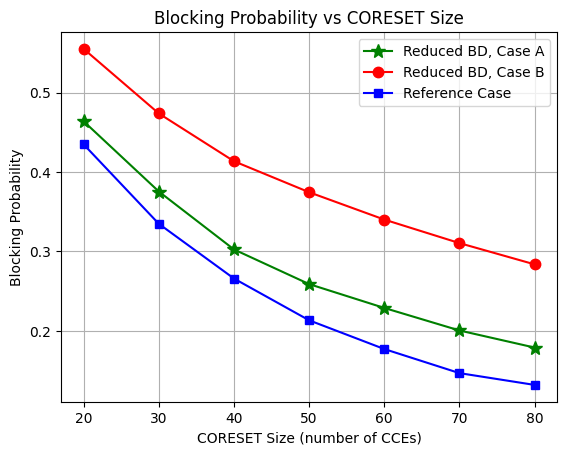

In [9]:
fig, ax = plt.subplots()
ax.plot(coresetSize, probOfBlockingBDCase_A, marker = "*",linestyle = "solid", ms = 10, c = 'g',label = "Reduced BD, Case A")
ax.plot(coresetSize, probOfBlockingBDCase_B, marker = "o",linestyle = "solid", ms = 7.5, c = 'r',label = "Reduced BD, Case B")
ax.plot(coresetSize, probOfBlockingRefCase,  marker = "s",linestyle = "solid", ms = 6, c = 'b',label = "Reference Case")

ax.legend()
ax.set_xlabel('CORESET Size (number of CCEs)')
ax.set_ylabel('Blocking Probability')
ax.set_title('Blocking Probability vs CORESET Size', fontsize=12) 
ax.set_xticks(coresetSize)
# ax.set_xlim([coresetSize[0], coresetSize[-1]])
ax.grid()
plt.show()

### References

[1] `Blocking Probability Analysis for 5G New Radio (NR) Physical Downlink Control Channel`. Mohammad Mozaffari,
      Y.-P. Eric Wang, and Kittipong Kittichokechai